<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import os
import numpy as np
import pandas as pd
import skimage.io
from skimage import io
from skimage.transform import resize
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [ ]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64):

    transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop((dx, dy)),
                transforms.Resize((dimx,dimy)),
                transforms.ToTensor()
        ])
    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(io.imread)\
                                 .apply(transform)

    all_photos = all_photos.values
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
batch_size = 32

ds_size = len(data)
train_coef = .8

train_size = int(train_coef * ds_size)
test_size = ds_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, test_size])

data_tr = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
data_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data_tr.dataset[i].permute(1, 2, 0))
plt.show()

In [ ]:
dim_code = 32 # выберите размер латентного вектора

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.ReLU):
        """
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        self.c_hid = base_channel_size

        self.encoder = nn.Sequential(
            nn.Conv2d(num_input_channels, self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(self.c_hid, 2*self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
        )

        self.flatten = nn.Flatten(start_dim=1)

        conv_size = int(np.exp2((np.log2(self.c_hid)-3)))
        ln_size = 2*self.c_hid*conv_size*conv_size

        self.linear = nn.Sequential(
            nn.Linear(ln_size, latent_dim)
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.ReLU):

        super().__init__()
        self.c_hid = base_channel_size

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*self.c_hid, self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(self.c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Sigmoid()
        )

        conv_size = int(np.exp2((np.log2(self.c_hid)-3)))
        ln_size = 2*self.c_hid*conv_size*conv_size

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, ln_size),
            act_fn()
        )

        self.unflatten = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(2*self.c_hid,conv_size, conv_size))
        )

    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 ):
        super().__init__()

        # Creating encoder and decoder
        self.encoder = encoder_class(
            num_input_channels=num_input_channels,
            base_channel_size=base_channel_size,
            latent_dim=latent_dim
        )
        self.decoder = decoder_class(
            num_input_channels=num_input_channels,
            base_channel_size=base_channel_size,
            latent_dim=latent_dim
        )

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [ ]:
criterion = nn.MSELoss()
img_size = 64

autoencoder = Autoencoder(
    num_input_channels=3,
    base_channel_size=img_size,
    latent_dim=dim_code,
)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, device="cpu", show=True):
    from time import time
    from tqdm.autonotebook import tqdm

    model=model.to(device)

    X_val = next(iter(data_val))

    train_losses = []
    val_losses = []

    log_template = "Epoch {ep:03d}/{epochs:03d}  train loss: {t_loss:0.4f} val loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            tic = time()

            avg_loss = 0
            model.train()  # train mode
            for X_batch in data_tr:
                # data to device
                X_batch= X_batch.to(device, dtype=torch.float32)

                # set parameter gradients to zero
                opt.zero_grad()

                # forward
                X_pred = model(X_batch)
                loss = loss_fn(X_batch, X_pred) # forward-pass
                loss.backward() # backward-pass
                opt.step() # update weights

                # calculate loss to show the user
                avg_loss += loss / len(data_tr)
            toc = time()

            # show intermediate results
            model.eval()  # testing mode
            X_hat = model(
                X_val.to(device, dtype=torch.float32)
            )

            X_hat = X_hat.detach().to('cpu')  # detach and put into cpu

            if scheduler:
                scheduler.step()

            train_losses.append(avg_loss.item())
            val_losses.append(loss_fn(X_val, X_hat).item())

            pbar_outer.update(1)

            # Visualize tools

            if show:
                clear_output(wait=True)
                plt.clf()
                for k in range(3):
                    plt.subplot(2, 3, k+1)
                    plt.imshow(X_val[k].permute(1, 2, 0))
                    plt.title('Real')
                    plt.axis('off')

                    plt.subplot(2, 3, k+4)
                    plt.imshow(X_hat[k].permute(1, 2, 0))
                    plt.title('Output')
                    plt.axis('off')
                plt.suptitle(
                    log_template.format(ep=epoch+1, epochs=epochs, t_loss=train_losses[-1], v_loss=val_losses[-1])
                )
                plt.show()
            else:
                tqdm.write(
                    log_template.format(ep=epoch+1, epochs=epochs, t_loss=train_losses[-1], v_loss=val_losses[-1])
                )

    return train_losses, val_losses, X_hat

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

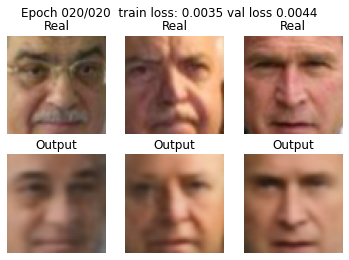

In [ ]:
max_epochs = 20

autoencoder_train_loss, autoencoder_val_loss, predict_img_val = train(
    model = autoencoder,
    opt = optimizer,
    loss_fn = criterion,
    epochs = max_epochs,
    data_tr = data_tr,
    data_val = data_val,
    device=device,
    show=True
)

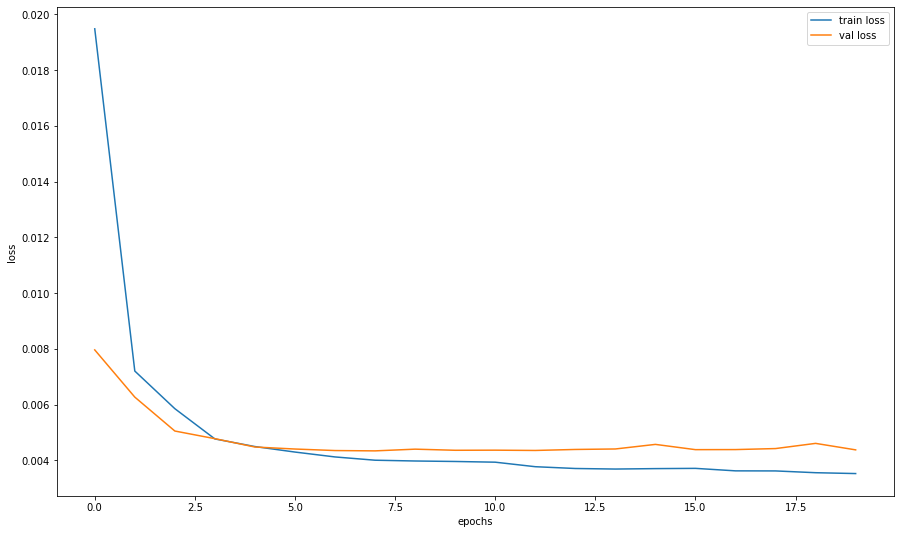

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(autoencoder_train_loss, label="train loss")
plt.plot(autoencoder_val_loss, label="val loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

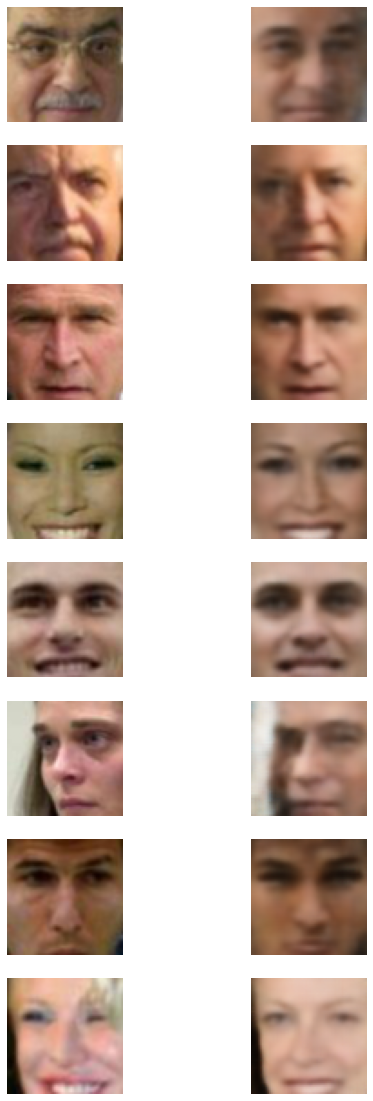

In [ ]:
def show(X_val, X_hat, X):
    plt.figure(figsize=(8, 20))
    for k in range(X):
        plt.subplot(X, 2, 2*k+1)
        plt.imshow(X_val[k].permute(1, 2, 0))
        plt.axis('off')
        plt.subplot(X, 2, 2*k+2)
        plt.imshow(X_hat[k].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

show(next(iter(data_val)), predict_img_val, 8)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
if autoencoder.training:
    autoencoder.eval()

In [ ]:
sample4late = torch.stack(data[attrs[attrs['Male'] > 1.0].astype(float).index].tolist()).to(device)

In [ ]:
late_vect = autoencoder.encoder(sample4late).cpu().detach()

In [ ]:
mu = torch.mean(late_vect, 0).to(device)
sigma = torch.std(late_vect, 0).to(device)

In [ ]:
z = torch.from_numpy(np.random.randn(25, dim_code, dim_code).astype(np.float32)).to(device)

In [ ]:
Z = (z+mu)*sigma

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
# z = torch.from_numpy(sigma*np.random.randn(25, dim_code, dim_code).astype(np.float32)+mu).to(device)
output_face = autoencoder.decoder(next(iter(Z))).cpu().detach()

In [ ]:
# z = torch.from_numpy(
#     np.random.randn(25, dim_code, dim_code).astype(np.float32)
# ).to(device)
# output_face = autoencoder.decoder(next(iter(z))).cpu().detach()

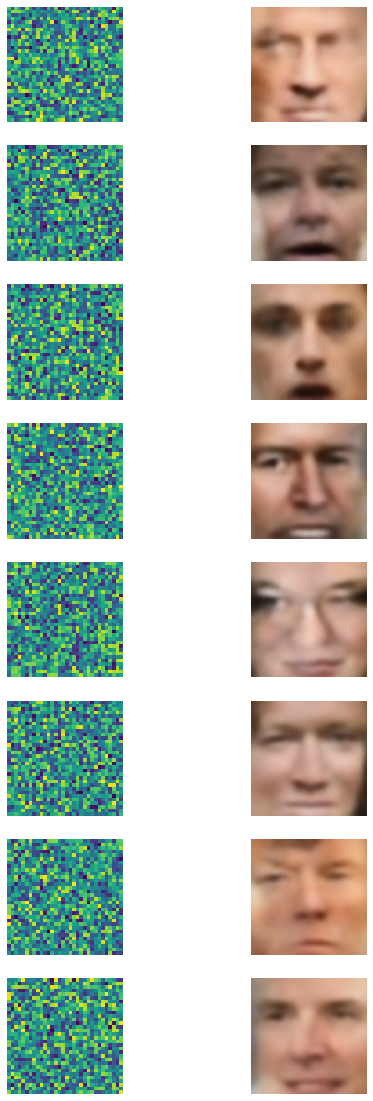

In [ ]:
k=8
z_img = nn.Sigmoid()(z)

plt.figure(figsize=(8, 20))
for i in range(k):
    plt.subplot(k, 2, 2*i+1)
    plt.imshow(z_img.cpu().detach()[i])
    plt.axis('off')
    plt.subplot(k, 2, 2*i+2)
    plt.imshow(output_face[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

## Для достижения более высокого качества выделим отдельно векторы улыбок:
## 1) мужчин и
## 2) женщин
## -- по атрибуту "Male".

1)

In [ ]:
smile_man_ind = attrs[attrs['Male'] > 1.5].Smiling.sort_values().tail(15).index.tolist()
sad_man_ind = attrs[attrs['Male'] > 1.0].Frowning.sort_values().tail(15).index.tolist()
data_smile_man = torch.stack(data[smile_man_ind].tolist())
data_sad_man = torch.stack(data[sad_man_ind].tolist())

latent_smile_man = autoencoder.encoder(data_smile_man.to(device))
latent_sad_man = autoencoder.encoder(data_sad_man.to(device))

img_sad_man = autoencoder(data_sad_man.to(device))
img_sad_man = img_sad_man.cpu().detach()

smile2sad_vector_man = torch.mean(latent_smile_man, dim=0)-torch.mean(latent_sad_man, dim=0)
latent_smile2sad_man = latent_sad_man + smile2sad_vector_man

img_smile2sad_man = autoencoder.decoder(latent_smile2sad_man).cpu().detach()

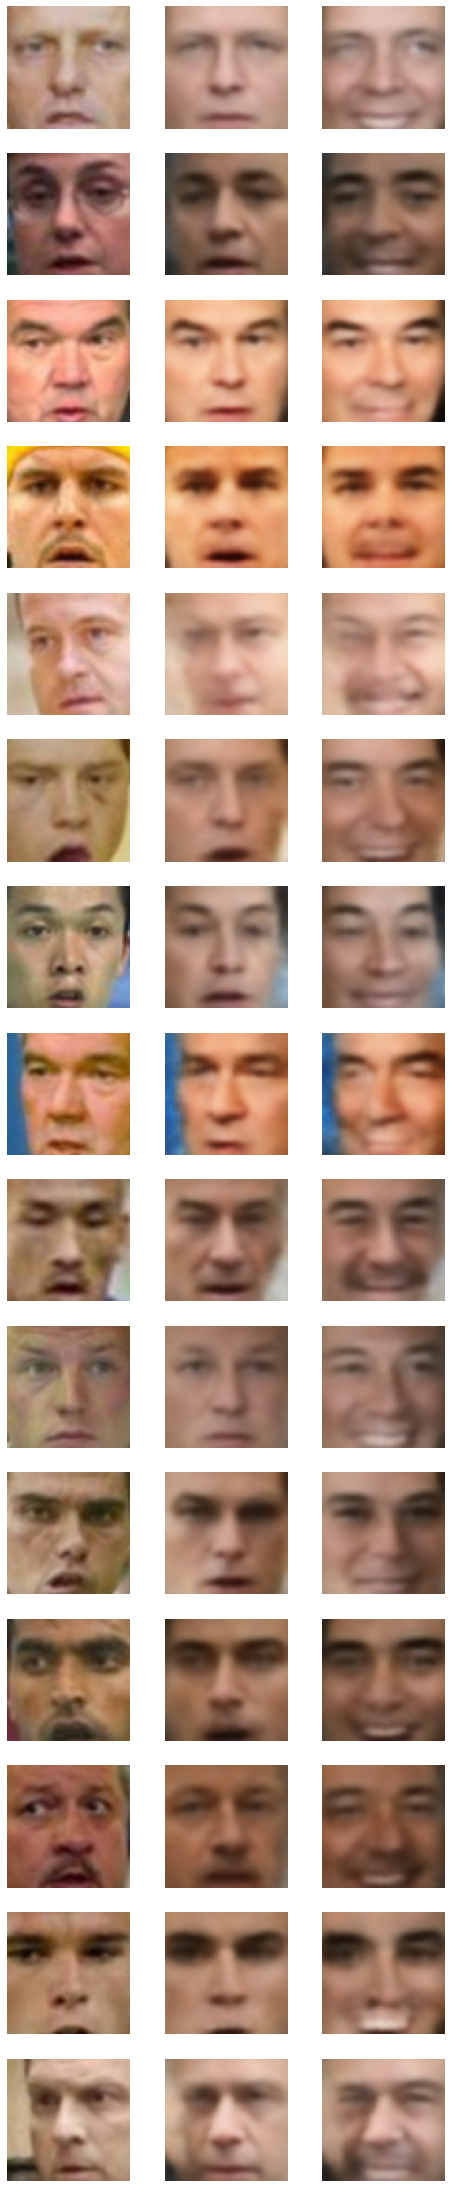

In [ ]:
k=15

plt.figure(figsize=(8, 40))
for i in range(k):
    plt.subplot(k, 3, 3*i+1)
    plt.imshow(data_sad_man[i].permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(k, 3, 3*i+2)
    plt.imshow(img_sad_man[i].permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(k, 3, 3*i+3)
    plt.imshow(img_smile2sad_man[i].permute(1, 2, 0))
    plt.axis('off')

plt.show()

2)

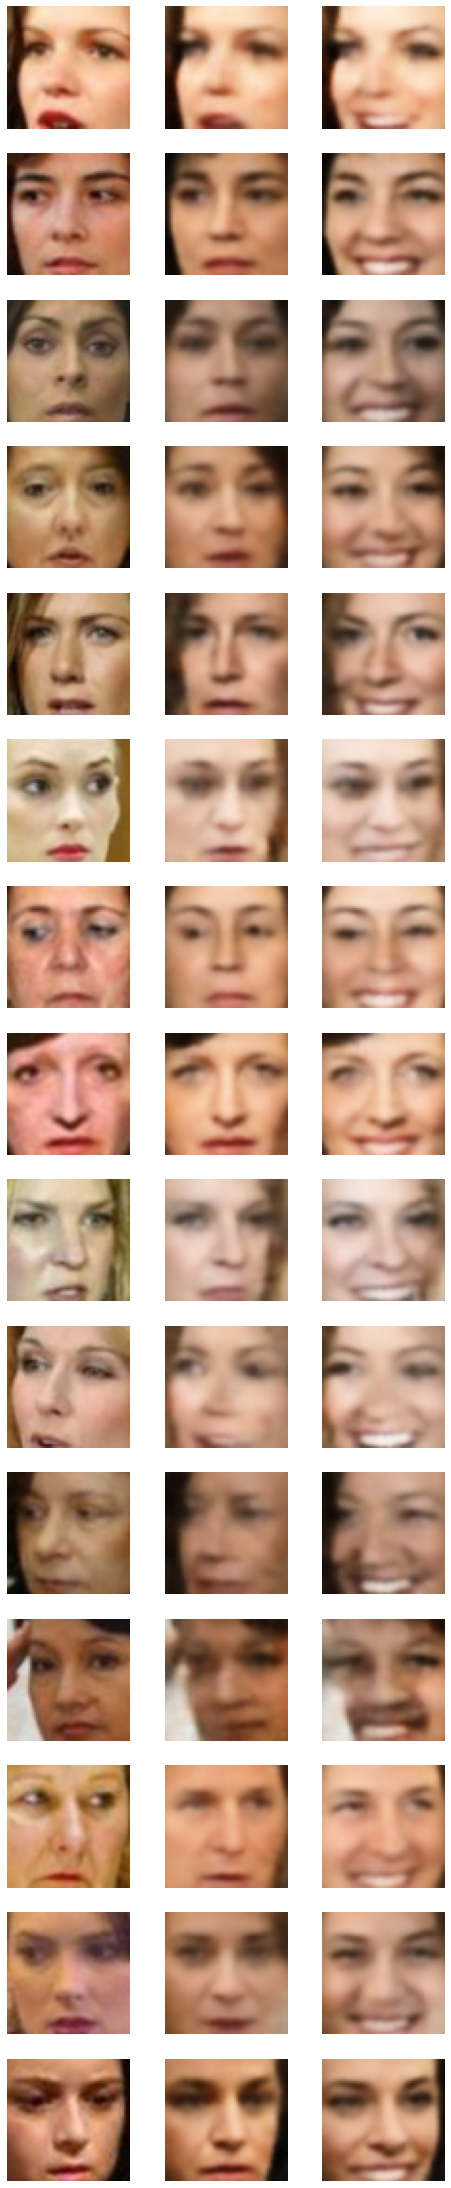

In [ ]:
smile_women_ind = attrs[attrs['Male'] < -1.5].Smiling.sort_values().tail(15).index.tolist()
sad_women_ind = attrs[attrs['Male'] < -1.5].Frowning.sort_values().tail(15).index.tolist()
data_smile_women = torch.stack(data[smile_women_ind].tolist())
data_sad_women = torch.stack(data[sad_women_ind].tolist())

latent_smile_women = autoencoder.encoder(data_smile_women.to(device))
latent_sad_women = autoencoder.encoder(data_sad_women.to(device))

img_sad_women = autoencoder(data_sad_women.to(device))
img_sad_women = img_sad_women.cpu().detach()

smile2sad_vector_women = torch.mean(latent_smile_women, dim=0)-torch.mean(latent_sad_women, dim=0)
latent_smile2sad_women = latent_sad_women + smile2sad_vector_women

img_smile2sad_women = autoencoder.decoder(latent_smile2sad_women).cpu().detach()

k=15

plt.figure(figsize=(8, 40))
for i in range(k):
    plt.subplot(k, 3, 3*i+1)
    plt.imshow(data_sad_women[i].permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(k, 3, 3*i+2)
    plt.imshow(img_sad_women[i].permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(k, 3, 3*i+3)
    plt.imshow(img_smile2sad_women[i].permute(1, 2, 0))
    plt.axis('off')

plt.show()

Вуаля! Вы восхитительны!

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
img_size = 32

transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.ToTensor()])
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', transform=transform, train=True, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', transform=transform, train=False, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_loader.dataset[0][0].shape

torch.Size([1, 32, 32])

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 num_input_channels: int = 3,
                 act_fn = nn.ReLU
                ):
        super().__init__()

        self.latent_dim = latent_dim
        self.c_hid = base_channel_size

        conv_size = int(np.exp2((np.log2(self.c_hid)-3)))
        ln_size = 2*self.c_hid*conv_size*conv_size

        self.encoder = nn.Sequential(
            nn.Conv2d(num_input_channels, self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(self.c_hid, 2*self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.linear_mu = nn.Sequential(
            nn.Linear(ln_size, latent_dim)
        )

        self.linear_logvar = nn.Sequential(
            nn.Linear(ln_size, latent_dim)
        )

        self.linear_decoder = nn.Sequential(
            nn.Linear(latent_dim, ln_size),
            act_fn()
        )

        self.unflatten = nn.Sequential(
            nn.Unflatten(
                dim=1,
                unflattened_size=(2*self.c_hid, conv_size, conv_size)
            )
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*self.c_hid, self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(self.c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Sigmoid()
        )


    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu

    def decode(self, x):
        x = self.linear_decoder(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return mu, logvar, z

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logvar):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logvar, reconstruction):
    kl = KL_divergence(mu, logvar)
    ll = log_likelihood(x, reconstruction)
    return kl + ll

И обучим модель:

In [ ]:
criterion = loss_vae

Vautoencoder = VAE(
    num_input_channels=1,
    base_channel_size=img_size,
    latent_dim=dim_code
)

optimizer = torch.optim.Adam(Vautoencoder.parameters(), lr=1e-3)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, device="cpu", show=True):
    from time import time
    from tqdm.autonotebook import tqdm

    model=model.to(device)

    X_val = next(iter(data_val))[0]

    train_losses = []
    val_losses = []

    log_template = "Epoch {ep:03d}/{epochs:03d}  train loss: {t_loss:0.4f} val loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            tic = time()

            avg_loss = 0
            model.train()  # train mode
            for X_batch, _ in data_tr:
                # data to device
                X_batch= X_batch.to(device, dtype=torch.float32)

                # set parameter gradients to zero
                opt.zero_grad()

                # forward
                mu, logvar, X_pred = model(X_batch)
                loss = loss_fn(X_batch, mu, logvar, X_pred) # forward-pass
                loss.backward() # backward-pass
                opt.step() # update weights

                # calculate loss to show the user
                avg_loss += loss / len(data_tr)
            toc = time()

            # show intermediate results
            model.eval()  # testing mode
            mu, logvar, X_hat = model(
                X_val.to(device, dtype=torch.float32)
            )

            X_hat = X_hat.detach().to('cpu')  # detach and put into cpu

            if scheduler:
                scheduler.step()

            train_losses.append(avg_loss.item())
            val_losses.append(loss_fn(X_val, mu, logvar, X_hat).item())

            pbar_outer.update(1)

            # Visualize tools
            if show:
                clear_output(wait=True)
                plt.clf()
                for k in range(3):
                    plt.subplot(2, 3, k+1)
                    plt.imshow(X_val[k].reshape([img_size, img_size]))
                    plt.title('Real')
                    plt.axis('off')

                    plt.subplot(2, 3, k+4)
                    plt.imshow(X_hat[k].reshape([img_size, img_size]))
                    plt.title('Output')
                    plt.axis('off')
                plt.suptitle(
                    log_template.format(ep=epoch+1, epochs=epochs, t_loss=train_losses[-1], v_loss=val_losses[-1])
                )
                plt.show()
            else:
                tqdm.write(
                    log_template.format(ep=epoch+1, epochs=epochs, t_loss=train_losses[-1], v_loss=val_losses[-1])
                )

    return train_losses, val_losses, X_hat, mu, logvar

In [ ]:
max_epochs = 50

vae_train_loss, vae_val_loss, predict_img_val, mu, logvar = train(
    model = Vautoencoder,
    opt = optimizer,
    loss_fn = criterion,
    epochs = max_epochs,
    data_tr = train_loader,
    data_val = test_loader,
    device=device,
    show=False
)

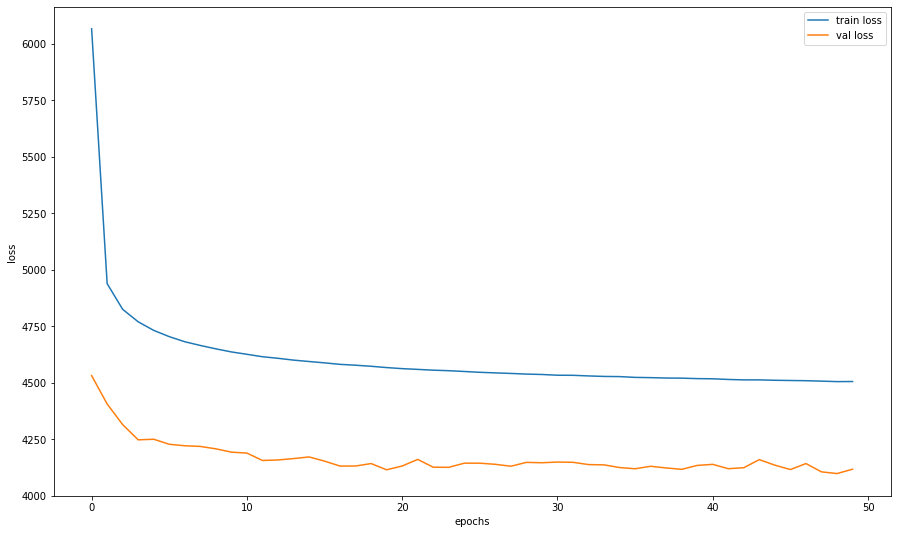

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(vae_train_loss, label="train loss")
plt.plot(vae_val_loss, label="val loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

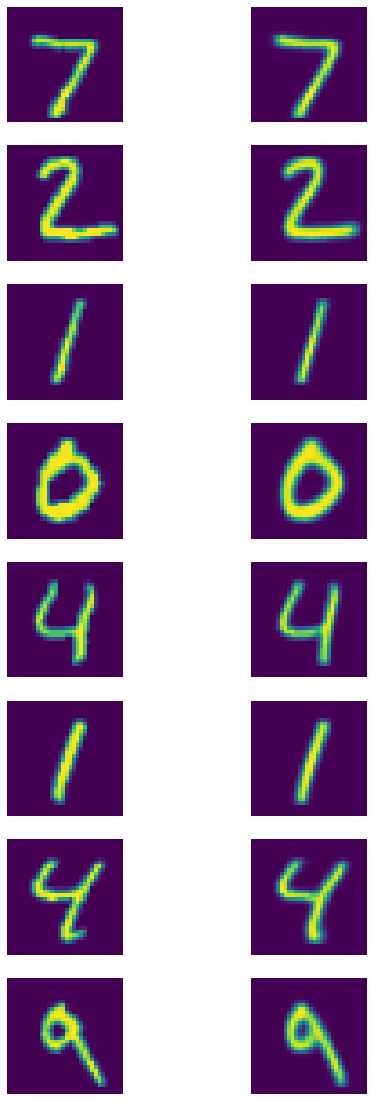

In [ ]:
def show(X_val, X_hat, X):
    plt.figure(figsize=(8, 20))
    for k in range(X):
        plt.subplot(X, 2, 2*k+1)
        plt.imshow(X_val[k].reshape([img_size, img_size]))
        plt.axis('off')
        plt.subplot(X, 2, 2*k+2)
        plt.imshow(X_hat[k].reshape([img_size, img_size]))
        plt.axis('off')
    plt.show()

show(next(iter(test_loader))[0], predict_img_val, 8)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
if Vautoencoder.training:
    Vautoencoder.eval()

In [ ]:
z = torch.from_numpy(
    np.random.randn(10, 32, 32).astype(np.float32)
).to(device)

In [ ]:
# z = torch.from_numpy(np.random.randn(10, dim_code, dim_code).astype(np.float32)).to(device)
# z = (z*0.8+mu.mean())*(logvar/2).exp().mean()

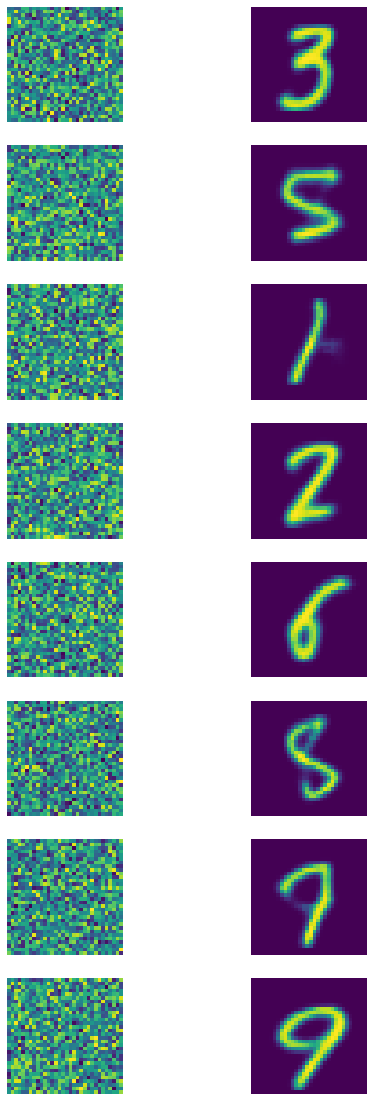

In [ ]:
output_num = Vautoencoder.decode(next(iter(z))).cpu().detach()

k=8
z_img = nn.Sigmoid()(z)

plt.figure(figsize=(8, 20))
for i in range(k):
    plt.subplot(k, 2, 2*i+1)
    plt.imshow(z_img.cpu().detach()[i])
    plt.axis('off')
    plt.subplot(k, 2, 2*i+2)
    plt.imshow(output_num[i].reshape([img_size, img_size]))
    plt.axis('off')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE

if Vautoencoder.training:
    Vautoencoder.eval()

In [ ]:
mu_val = torch.Tensor()
label_val = torch.Tensor()

for batch, label in test_loader:
    mu, logvar, X_pred = Vautoencoder(batch.to(device))
    mu_val = torch.cat((mu_val, mu.to('cpu')), 0)
    label_val = torch.cat((label_val, label.to('cpu')), dim=0)

mu_val_TSNE = torch.from_numpy(TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(mu_val.detach()))
mu_val_embedded = torch.cat((mu_val_TSNE, label_val.view(-1, 1)), dim = 1)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


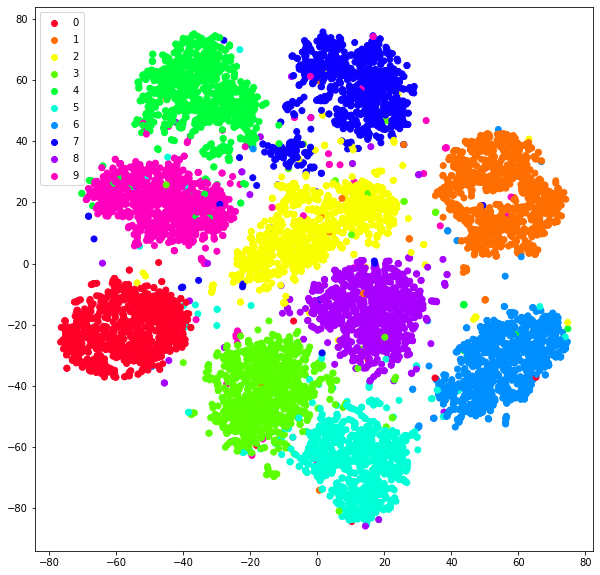

In [ ]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    mu_val_embedded[:, 0],
    mu_val_embedded[:, 1],
    c=mu_val_embedded[:, 2],
    cmap='gist_rainbow'
)
plt.legend(*scatter.legend_elements())
plt.show()

Что вы думаете о виде латентного представления?

- Области для каждой группы хорошо разделенны между собой, компактно сгруппириованны и логично расположены по схожести.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


In [ ]:
class CVAE(nn.Module):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 num_classes: int,
                 num_input_channels: int = 3,
                 act_fn = nn.ReLU
                ):
        super().__init__()

        self.dummy_param = nn.Parameter(torch.empty(0))

        self.latent_dim = latent_dim
        self.c_hid = base_channel_size
        self.num_classes = num_classes

        conv_size = int(np.exp2((np.log2(self.c_hid)-3)))
        ln_size = 2*self.c_hid*conv_size*conv_size

        self.encoder = nn.Sequential(
            nn.Conv2d(num_input_channels, self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(self.c_hid, 2*self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.linear_mu = nn.Sequential(
            nn.Linear(ln_size, latent_dim)
        )

        self.linear_logvar = nn.Sequential(
            nn.Linear(ln_size, latent_dim)
        )

        self.linear_decoder = nn.Sequential(
            nn.Linear(latent_dim+num_classes, ln_size),
            act_fn()
        )

        self.unflatten = nn.Sequential(
            nn.Unflatten(
                dim=1,
                unflattened_size=(2*self.c_hid, conv_size, conv_size)
            )
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*self.c_hid, self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(self.c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu

    def decode(self, x):
        x = self.linear_decoder(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

    def forward(self, x, **kwargs):
        y = kwargs['labels']
        y = torch.nn.functional.one_hot(y, num_classes=self.num_classes)

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        z = torch.cat([z, y], dim = 1)

        z = self.decode(z)
        return mu, logvar, z

    def sample(self, labels: list):
        y = torch.tensor(labels, dtype=torch.int64).to(self.dummy_param.device)
        y = torch.nn.functional.one_hot(y, num_classes=self.num_classes)
        z = torch.randn(y.size()[0], 32).to(self.dummy_param.device)
        z = torch.cat([z, y], dim=1)
        return self.decode(z)

In [ ]:
criterion = loss_vae

CVautoencoder = CVAE(
    num_input_channels=1,
    base_channel_size=img_size,
    num_classes=train_dataset.targets.unique().size()[0],
    latent_dim=dim_code
)

optimizer = torch.optim.Adam(CVautoencoder.parameters(), lr=1e-3)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, device="cpu", show=True, show_num=3):
    from time import time
    from tqdm.autonotebook import tqdm

    model=model.to(device)

    X_val, Y_val = next(iter(data_val))

    train_losses = []
    val_losses = []

    log_template = "Epoch {ep:03d}/{epochs:03d}  train loss: {t_loss:0.4f} val loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            tic = time()

            avg_loss = 0
            model.train()  # train mode
            for X_batch, Y_batch in data_tr:
                # data to device
                X_batch = X_batch.to(device, dtype=torch.float32)
                Y_batch = Y_batch.to(device)

                # set parameter gradients to zero
                opt.zero_grad()

                # forward
                mu, logvar, X_pred = model(X_batch, labels=Y_batch)
                loss = loss_fn(X_batch, mu, logvar, X_pred) # forward-pass
                loss.backward() # backward-pass
                opt.step() # update weights

                # calculate loss to show the user
                avg_loss += loss / len(data_tr)
            toc = time()

            # show intermediate results
            model.eval()  # testing mode
            mu, logvar, X_hat = model(
                X_val.to(device, dtype=torch.float32),
                labels=Y_val.to(device)
            )

            X_hat = X_hat.detach().to('cpu')  # detach and put into cpu

            train_losses.append(avg_loss.item())
            val_losses.append(loss_fn(X_val, mu, logvar, X_hat).item())

            nums = np.random.randint(10, size=show_num)
            output_nums = model.sample(nums).detach()
            output_nums = output_nums.detach().to('cpu')

            if scheduler:
                scheduler.step()

            pbar_outer.update(1)

            # Visualize tools

            if show:
                clear_output(wait=True)
                plt.clf()
                for k in range(show_num):
                    plt.subplot(3, show_num, k+1)
                    plt.imshow(X_val[k].reshape(img_size,img_size))
                    plt.title(f'Real {Y_val[k]}')
                    plt.axis('off')

                    plt.subplot(3, show_num, k+1+show_num)
                    plt.imshow(X_hat[k].reshape(img_size,img_size))
                    plt.title(f'Output {Y_val[k]}')
                    plt.axis('off')

                    plt.subplot(3, show_num, k+1+2*show_num)
                    plt.imshow(output_nums[k].reshape(img_size,img_size))
                    plt.title(f'Class {nums[k]}')
                    plt.axis('off')
                plt.suptitle(
                    log_template.format(ep=epoch+1, epochs=epochs, t_loss=train_losses[-1], v_loss=val_losses[-1])
                )
                plt.show()
            else:
                tqdm.write(
                    log_template.format(ep=epoch+1, epochs=epochs, t_loss=train_losses[-1], v_loss=val_losses[-1])
                )

    return train_losses, val_losses, X_hat, mu, logvar

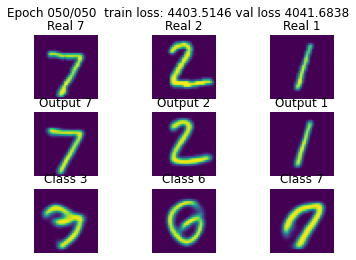

In [ ]:
max_epochs = 50

cvae_train_loss, cvae_val_loss, cvae_predict_img_val, cvae_mu, cvae_logvar = train(
    model = CVautoencoder,
    opt = optimizer,
    loss_fn = criterion,
    epochs = max_epochs,
    data_tr = train_loader,
    data_val = test_loader,
    device=device,
    show=True
)

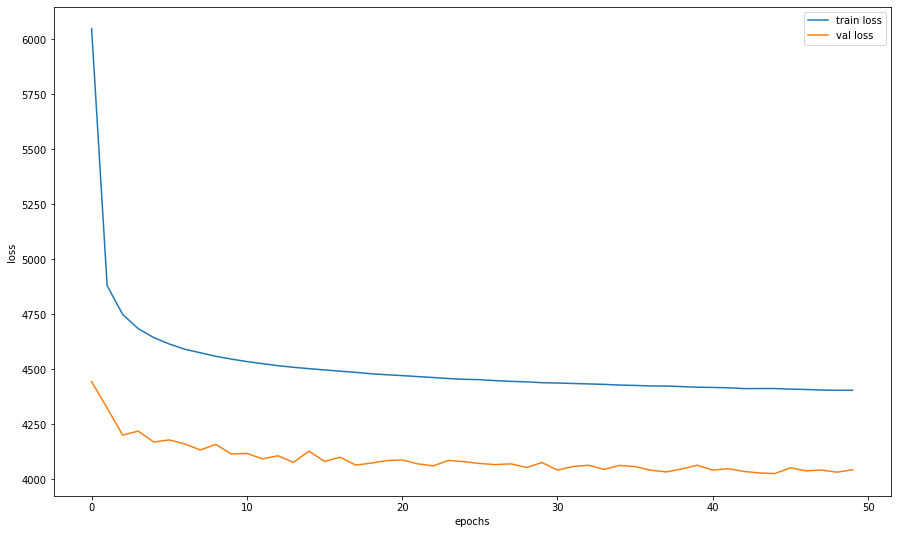

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(cvae_train_loss, label="train loss")
plt.plot(cvae_val_loss, label="val loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

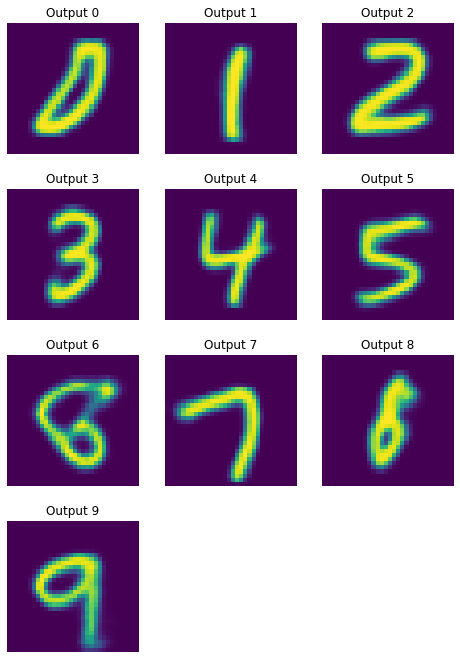

In [ ]:
nums = range(10)
output_num = CVautoencoder.sample(nums).cpu().detach()

plt.figure(figsize=(8, len(nums)*3))
for i, n in enumerate(nums):
    plt.subplot(len(nums), 3, i+1)
    plt.imshow(output_num[i].reshape(img_size,img_size))
    plt.title(f'Output {n}')
    plt.axis('off')
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
if CVautoencoder.training:
    CVautoencoder.eval()

In [ ]:
mu_val = torch.Tensor()
label_val = torch.Tensor()

for batch, label in test_loader:
    mu, logvar, X_pred = CVautoencoder(batch.to(device), labels=label.to(device))
    mu_val = torch.cat((mu_val, mu.to('cpu')), 0)
    label_val = torch.cat((label_val, label.to('cpu')), dim=0)

In [ ]:
mu_val_TSNE = torch.from_numpy(TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(mu_val.detach()))
mu_val_embedded = torch.cat((mu_val_TSNE, label_val.view(-1, 1)), dim = 1)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


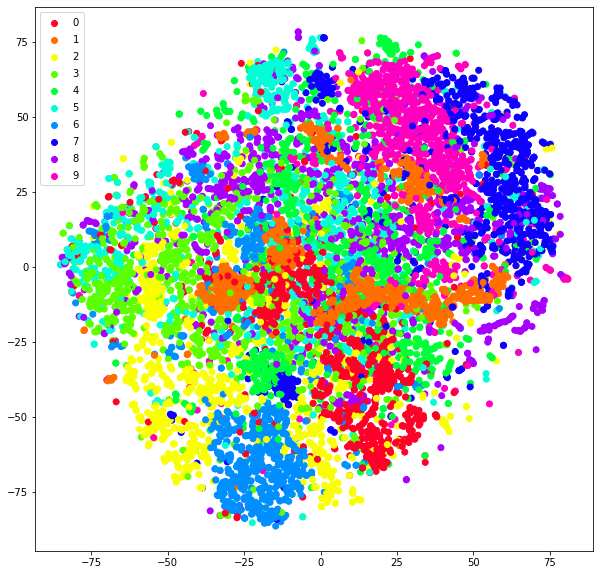

In [ ]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    mu_val_embedded[:, 0],
    mu_val_embedded[:, 1],
    c=mu_val_embedded[:, 2],
    cmap='gist_rainbow'
)
plt.legend(*scatter.legend_elements())
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

- Определённо. Классы сильно перемещены и более пространстенно распределены, нет такой отчётливой агрегации для каждого класса как для VAE.